In [9]:
import os
import glob
import torch
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1

In [44]:
mtcnn = MTCNN(image_size=160, margin=0, keep_all=True)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

def show(subplot: tuple, mat: list, figsize=(10, 10)):
    fig, ax = plt.subplots(subplot[0], subplot[1], figsize=figsize)
    for i, axi in enumerate(ax):
        axi.imshow((mat[i].numpy() / 2 + 0.5))
        axi.axis('off')
    
    plt.show()

def save(path, mat):
    img = mat.numpy() / 2 + 0.5
    plt.imsave(path, img)

def cos_sim(a, b):
    a = a.detach().numpy()
    b = b.T.detach().numpy()
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


In [20]:
img_1 = Image.open("../data/img1.jpg")
cropped_img1 = mtcnn(img_1)
cropped_img1 = rearrange(cropped_img1, 'b c h w -> b h w c')
cropped_img1.shape

torch.Size([2, 160, 160, 3])

In [21]:
img_2 = Image.open("../data/img2.jpg")
cropped_img2 = mtcnn(img_2)
cropped_img2 = rearrange(cropped_img2, 'b c h w -> b h w c')
cropped_img2.shape

torch.Size([1, 160, 160, 3])

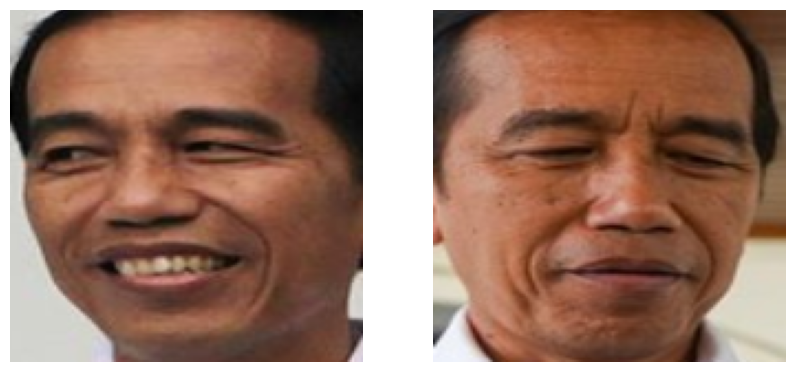

In [23]:
show((1, 2), [cropped_img1[0], cropped_img2[0]])

In [24]:
person_A = rearrange(cropped_img1[0].unsqueeze(0), 'b h w c -> b c h w')
person_B = rearrange(cropped_img2[0].unsqueeze(0), 'b h w c -> b c h w')
person_C = rearrange(cropped_img1[1].unsqueeze(0), 'b h w c -> b c h w')

embed_A = resnet(person_A)
embed_B = resnet(person_B)
embed_C = resnet(person_C)

In [25]:
cos_sim(embed_A, embed_B), cos_sim(embed_A, embed_C)

(array([[0.84355074]], dtype=float32), array([[0.04549363]], dtype=float32))

In [102]:
# make imagefolder logic
path = os.path.join("../data/output")
embed_path = os.path.join("../data/embed")
imgs = glob.glob("../data/*")
unique_person_counter = 0

if not os.path.isdir(path):
    os.mkdir(path)

def compare_embed(embed_source, path, file_type="pt", threshold=0.6):
    embeds = glob.glob(path + f"/*.{file_type}")
    for i, embed in enumerate(embeds):
        embed_target = torch.load(embed)
        if cos_sim(embed_source, embed_target) > threshold:
            return embed
    else:
        return False

for i, img in enumerate(imgs):
    crop_all = mtcnn(Image.open(img))
    if i == 0:
        for j, crop in enumerate(crop_all):
            img_dir = os.path.join(path, f"person_{j}")
            if not os.path.isdir(img_dir):
                os.mkdir(img_dir)
            
            # save image
            save(f"{img_dir}/{i}_person {unique_person_counter}.jpg",
                 rearrange(crop, "c h w -> h w c"))
            
            # save embed
            if not os.path.isdir(embed_path):
                os.mkdir(embed_path)
                
            embed = resnet(crop.unsqueeze(0))
            torch.save(embed, f"{embed_path}/{i}_person {unique_person_counter}.pt")
            unique_person_counter += 1
    else:
        for j, crop in enumerate(crop_all):
            is_exist = compare_embed(resnet(crop.unsqueeze(0)), embed_path, threshold=0.7)
            
            if is_exist != False:
                person = is_exist.split("\\")[-1].split("_")[0]
                img_dir = os.path.join(path, f"person_{person}")

                # save image
                save(f"{img_dir}/{i}_person {person}.jpg",
                     rearrange(crop, "c h w -> h w c"))
                
                # save embed
                embed = resnet(crop.unsqueeze(0))
                torch.save(
                    embed, f"{embed_path}/{i}_person {person}.pt")
            else:
                img_dir = os.path.join(path, f"person_{unique_person_counter}")
                if not os.path.isdir(img_dir):
                    os.mkdir(img_dir)
                
                # save image
                save(f"{img_dir}/{i}_person {unique_person_counter}.jpg",
                     rearrange(crop, "c h w -> h w c"))
                
                # save embed
                embed = resnet(crop.unsqueeze(0))
                torch.save(embed, f"{embed_path}/{i}_person {unique_person_counter}.pt")
                unique_person_counter += 1

In [103]:
# prototype group-based association

def get_person_occurance(output_path):
    people = glob.glob(f"{output_path}*")
    group = {}
    
    for person in people:
        person_i = glob.glob(person + "/*")
        person_i = [i.split("\\")[-1] for i in person_i]
        person_i = [i.split("_")[0] for i in person_i]
        current_person = person.split("\\")[-1]
        group[current_person] = person_i
    
    return group

def find_shared_positions(people_positions):
    shared_positions = []
    already_processed = set()

    for person1, positions1 in people_positions.items():
        for person2, positions2 in people_positions.items():
            if person1 != person2 and (person2, person1) not in already_processed:
                common_positions = set(positions1) & set(positions2)

                for position in common_positions:
                    shared_positions.append([person1, person2, int(position)])
                    already_processed.add((person1, person2))

    return shared_positions

group = get_person_occurance("../data/output/")
shared_positions = find_shared_positions(group)

print(group)
print(shared_positions)

{'person_0': ['0', '1', '3', '4', '6', '7', '8', '9'], 'person_1': ['1'], 'person_10': ['8'], 'person_11': ['9'], 'person_12': ['9'], 'person_13': ['9'], 'person_2': ['1', '4', '5', '7'], 'person_3': ['1', '9'], 'person_4': ['1'], 'person_5': ['1'], 'person_6': ['1'], 'person_7': ['1'], 'person_8': ['2'], 'person_9': ['3']}
[['person_0', 'person_1', 1], ['person_0', 'person_10', 8], ['person_0', 'person_11', 9], ['person_0', 'person_12', 9], ['person_0', 'person_13', 9], ['person_0', 'person_2', 4], ['person_0', 'person_2', 1], ['person_0', 'person_2', 7], ['person_0', 'person_3', 9], ['person_0', 'person_3', 1], ['person_0', 'person_4', 1], ['person_0', 'person_5', 1], ['person_0', 'person_6', 1], ['person_0', 'person_7', 1], ['person_0', 'person_9', 3], ['person_1', 'person_2', 1], ['person_1', 'person_3', 1], ['person_1', 'person_4', 1], ['person_1', 'person_5', 1], ['person_1', 'person_6', 1], ['person_1', 'person_7', 1], ['person_11', 'person_12', 9], ['person_11', 'person_13', 9]

In [104]:
association_df = pd.DataFrame(shared_positions, columns=["person1", "person2", "position"])
association_df.drop(["position"], axis=1, inplace=True)

association_df["value"] = 1
association_df = association_df.groupby(["person1","person2"], sort=False, as_index=False).sum()
association_df

,person1,person2,value
0,person_0,person_1,1
1,person_0,person_10,1
2,person_0,person_11,1
3,person_0,person_12,1
4,person_0,person_13,1
5,person_0,person_2,3
6,person_0,person_3,2
7,person_0,person_4,1
8,person_0,person_5,1
9,person_0,person_6,1


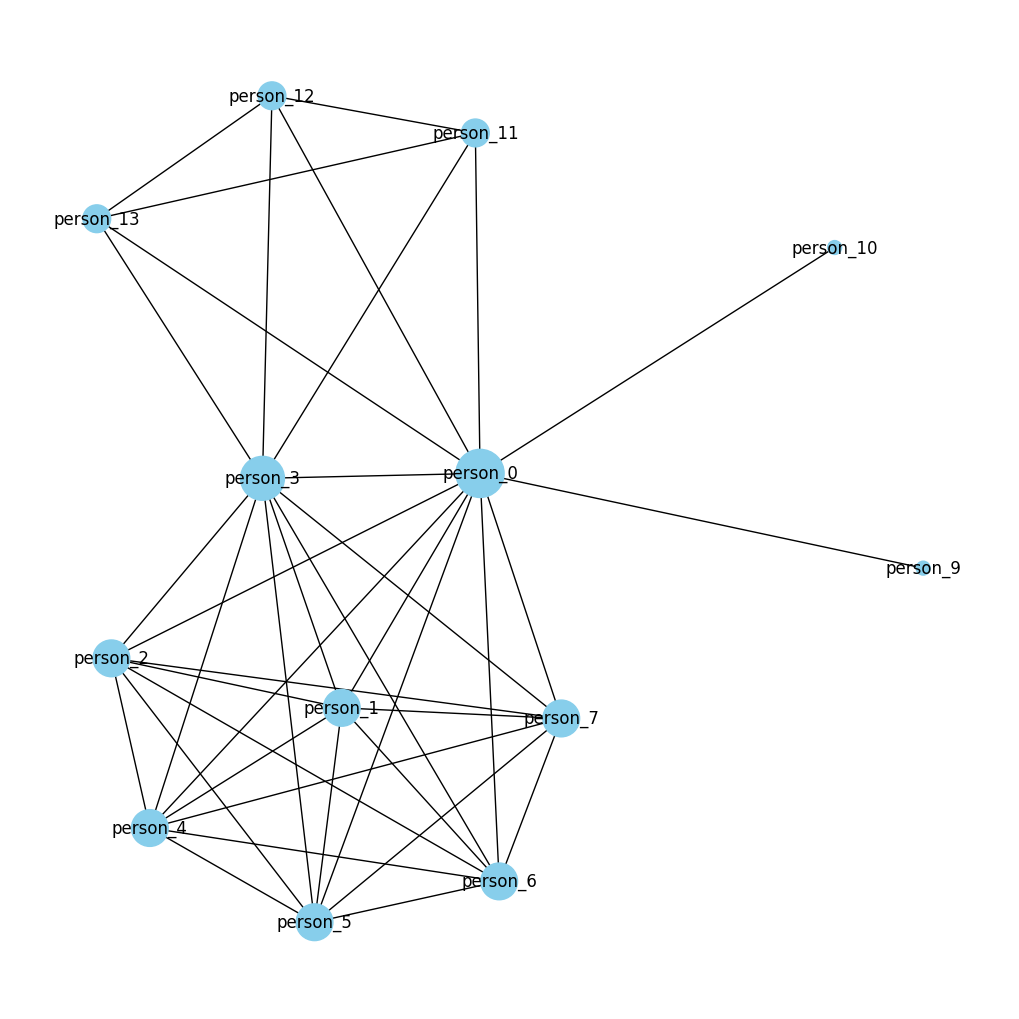

In [106]:
G = nx.from_pandas_edgelist(association_df, 'person1',
                            'person2', edge_attr="value", create_using=nx.Graph())

plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
node_degree = dict(G.degree())

nx.draw(G, with_labels=True, node_color='skyblue',
        edge_cmap=plt.cm.Blues, pos=pos,
        node_size=[v * 100 for v in node_degree.values()]
        )

plt.show()